In [1]:
import re
import ast
import nltk
import random
import datetime
import pandas as pd
nltk.download('punkt')
from tqdm import tqdm
tqdm.pandas()
import seaborn as sns
from numerize import numerize 
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FuncFormatter

[nltk_data] Downloading package punkt to /home/dina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
def step_one_pairs(list_of_items):
    return [(list_of_items[i],list_of_items[i+1]) for i in range(len(list_of_items)-1)]

### Load data before preprocessing

In [5]:
print('Reading file...')
df = pd.read_csv('../out_files/tell_all_FILLED.csv')
df = df[df['speech'].notna()]

print(df.tail(2))

In [4]:
df = df.rename(columns={'parliamentary_period': 'period'})

df.period = df.period.apply(lambda x: x.replace(' review 9',''))
df.period = df.period.apply(lambda x: x.replace('period ',''))

df.period = df.period.astype(int)

print(datetime.datetime.now())

#Group speeches by period
PERperiod_df_original = df.groupby(df.period)['speech'].progress_apply(' '.join).reset_index()

print(datetime.datetime.now())

In [4]:
# Sort periods based on number in the string

periods = sorted(PERperiod_df_original.period.to_list())
period_pairs = step_one_pairs(periods)
print(period_pairs)

[(5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18)]


In [5]:
PERperiod_df_original['vocab'] = PERperiod_df_original.speech.progress_apply(lambda x: nltk.word_tokenize(x.lower()))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [12:52<00:00, 55.21s/it]


Compute vocabulary/token intersection between pairs of periods

In [6]:
common_vocab = []

for pair in period_pairs:
    
    s1 = set(PERperiod_df_original.loc[(PERperiod_df_original.period==pair[0])].vocab.values[0])
    s2 = set(PERperiod_df_original.loc[(PERperiod_df_original.period==pair[1])].vocab.values[0])
    common_voc = len(s1.intersection(s2))
    common_vocab.append([pair, common_voc])
    
common_vocab_df_original = pd.DataFrame(common_vocab, columns = ['pair', 'common_vocab'])
# common_vocab_df_original.to_csv('../out_files/common_vocab_df_original.csv', index=False)
print(common_vocab_df_original.head(2))

     pair  common_vocab
0  (5, 6)         30043
1  (6, 7)         46959


### Load data after preprocessing

In [1]:
print('Reading file...')
df_cleaned = pd.read_csv('../out_files/tell_all_cleaned.csv')
df_cleaned = df_cleaned[df_cleaned['speech'].notna()]

print(df_cleaned.head(2))

Reading file...
                    member_name sitting_date parliamentary_period  \
0  κρητικος νικολαου παναγιωτης   03/07/1989             period 5   
1  κρητικος νικολαου παναγιωτης   03/07/1989             period 5   

  parliamentary_session parliamentary_sitting                 political_party  \
0             session 1             sitting 1  πανελληνιο σοσιαλιστικο κινημα   
1             session 1             sitting 1  πανελληνιο σοσιαλιστικο κινημα   

                                     government member_region  \
0  ['τζαννετακη τζαννη(02/07/1989-12/10/1989)']   β' πειραιως   
1  ['τζαννετακη τζαννη(02/07/1989-12/10/1989)']   β' πειραιως   

                                              roles member_gender  \
0  ['δ αντιπροεδρος βουλης(07/03/1989-21/11/1989)']          male   
1  ['δ αντιπροεδρος βουλης(07/03/1989-21/11/1989)']          male   

  speaker_info                                             speech  
0   προεδρευων  παρακαλειται @sw γραμματεας βουλγαρακης @sw 

In [2]:
df_cleaned = df_cleaned.rename(columns={'parliamentary_period': 'period'})

df_cleaned.period = df_cleaned.period.apply(lambda x: x.replace(' review 9',''))
df_cleaned.period = df_cleaned.period.apply(lambda x: x.replace('period ',''))

df_cleaned.period = df_cleaned.period.astype(int)

print(datetime.datetime.now())

PERperiod_df_cleaned = df_cleaned.groupby(df_cleaned.period)['speech'].progress_apply('. '.join).reset_index() #concat sentences, each last sentence for each speech did not have dot so add one.

print(datetime.datetime.now())

In [12]:
periods_cleaned = sorted(PERperiod_df_cleaned.period.to_list())
period_pairs_cleaned = step_one_pairs(periods_cleaned)
print(period_pairs_cleaned)

[(5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18)]


In [13]:
PERperiod_df_cleaned['vocab'] = PERperiod_df_cleaned.speech.progress_apply(lambda x: nltk.word_tokenize(x))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [12:11<00:00, 52.27s/it]


In [14]:
common_vocab_cleaned = []

for pair in period_pairs_cleaned:
    
    s1 = set(PERperiod_df_cleaned.loc[(PERperiod_df_cleaned.period==pair[0])].vocab.values[0])
    s2 = set(PERperiod_df_cleaned.loc[(PERperiod_df_cleaned.period==pair[1])].vocab.values[0])
    common_voc = len(s1.intersection(s2))
    common_vocab_cleaned.append([pair, common_voc])
    
common_vocab_df_cleaned = pd.DataFrame(common_vocab_cleaned, columns = ['pair', 'common_vocab'])
common_vocab_df_cleaned.to_csv('../out_files/common_vocab_df_cleaned.csv', index=False)

print(common_vocab_df_cleaned.head(2))

     pair  common_vocab
0  (5, 6)         27439
1  (6, 7)         43915


### Load data after merging periods

In [6]:
df_merged_cleaned = df_cleaned.copy()

In [7]:
df_merged_cleaned.loc[(df_merged_cleaned.period==5), 'period'] = 7
df_merged_cleaned.loc[(df_merged_cleaned.period==6), 'period'] = 7
df_merged_cleaned.loc[(df_merged_cleaned.period==14), 'period'] = 15
df_merged_cleaned.loc[(df_merged_cleaned.period==16), 'period'] = 17


In [8]:
PERperiod_df_merged_cleaned = df_merged_cleaned.groupby(df_merged_cleaned.period)['speech'].progress_apply('. '.join).reset_index() #concat sentences, each last sentence for each speech did not have dot so add one.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 21.74it/s]


In [9]:
periods_merged_cleaned = sorted(PERperiod_df_merged_cleaned.period.to_list())
print(periods_merged_cleaned)

period_pairs_merged_cleaned = step_one_pairs(periods_merged_cleaned)
print(period_pairs_merged_cleaned)

[7, 8, 9, 10, 11, 12, 13, 15, 17, 18]
[(7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 15), (15, 17), (17, 18)]


In [10]:
PERperiod_df_merged_cleaned['vocab'] = PERperiod_df_merged_cleaned.speech.progress_apply(lambda x: nltk.word_tokenize(x))


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [11:47<00:00, 70.72s/it]


In [11]:
common_vocab_merged_cleaned = []

for pair in period_pairs_merged_cleaned:
    print(pair)
    
    s1 = set(PERperiod_df_merged_cleaned.loc[(PERperiod_df_merged_cleaned.period==pair[0])].vocab.values[0])
    s2 = set(PERperiod_df_merged_cleaned.loc[(PERperiod_df_merged_cleaned.period==pair[1])].vocab.values[0])
    common_voc = len(s1.intersection(s2))
    common_vocab_merged_cleaned.append([pair, common_voc])
    
common_vocab_df_merged_cleaned = pd.DataFrame(common_vocab_merged_cleaned, columns = ['pair', 'common_vocab'])
common_vocab_df_merged_cleaned.to_csv('../out_files/common_vocab_df_merged_cleaned.csv', index=False)

print(common_vocab_df_merged_cleaned.head(2))

(7, 8)
(8, 9)
(9, 10)
(10, 11)
(11, 12)
(12, 13)
(13, 15)
(15, 17)
(17, 18)
     pair  common_vocab
0  (7, 8)         93171
1  (8, 9)         86361


### Visualize common vocabulary

In [3]:
periods = {
    5: (1989, 1989),
    6: (1989, 1990),
    7: (1990, 1993),
    8: (1993, 1996),
    9: (1996, 2000),
    10: (2000, 2004),
    11: (2004, 2007),
    12: (2007, 2009),
    13: (2009, 2012),
    14: (2012, 2012),
    15: (2012, 2014),
    16: (2015, 2015),
    17: (2015, 2019),
    18: (2019, 2020)
}

merged_periods = {
    7: (1989, 1993),
    8: (1993, 1996),
    9: (1996, 2000),
    10: (2000, 2004),
    11: (2004, 2007),
    12: (2007, 2009),
    13: (2009, 2012),
    15: (2012, 2014),
    17: (2015, 2019),
    18: (2019, 2020)
}

common_vocab_df_original = pd.read_csv('../out_files/common_vocab_df_original.csv', converters={"pair": ast.literal_eval})
common_vocab_df_original['version'] = 'without preprocessing'
common_vocab_df_original['period_start'] = common_vocab_df_original['pair'].map(lambda x: periods[x[0]][0])
common_vocab_df_original['period_end'] = common_vocab_df_original['pair'].map(lambda x: periods[x[1]][1])
common_vocab_df_original['period_middle'] = ((common_vocab_df_original['period_start'] 
                                        + common_vocab_df_original['period_end']) / 2)

common_vocab_df_cleaned = pd.read_csv('../out_files/common_vocab_df_cleaned.csv', converters={"pair": ast.literal_eval})
common_vocab_df_cleaned['version'] = 'with preprocessing'
common_vocab_df_cleaned['period_start'] = common_vocab_df_cleaned['pair'].map(lambda x: periods[x[0]][0])
common_vocab_df_cleaned['period_end'] = common_vocab_df_cleaned['pair'].map(lambda x: periods[x[1]][1])
common_vocab_df_cleaned['period_middle'] = ((common_vocab_df_cleaned['period_start'] 
                                        + common_vocab_df_cleaned['period_end']) / 2)


common_vocab_df_merged_cleaned = pd.read_csv('../out_files/common_vocab_df_merged_cleaned.csv', converters={"pair": ast.literal_eval})
common_vocab_df_merged_cleaned['version'] = 'with preprocessing and merging'

common_vocab_df_merged_cleaned['period_start'] = common_vocab_df_merged_cleaned['pair'].map(lambda x: merged_periods[x[0]][0])
common_vocab_df_merged_cleaned['period_end'] = common_vocab_df_merged_cleaned['pair'].map(lambda x: merged_periods[x[1]][1])
common_vocab_df_merged_cleaned['period_middle'] = ((common_vocab_df_merged_cleaned['period_start'] 
                                        + common_vocab_df_merged_cleaned['period_end']) / 2)

In [5]:
all_versions_df = common_vocab_df_original.append(common_vocab_df_cleaned).append(common_vocab_df_merged_cleaned)

In [6]:
# all_versions_df.to_csv('../out_files/all_versions_common_vocab.csv', index=False)

In [7]:
all_versions_df

,pair,common_vocab,version,period_start,period_end,period_middle
0,"(5, 6)",30043,without preprocessing,1989,1990,1989.5
1,"(6, 7)",46959,without preprocessing,1989,1993,1991.0
2,"(7, 8)",95910,without preprocessing,1990,1996,1993.0
3,"(8, 9)",91904,without preprocessing,1993,2000,1996.5
4,"(9, 10)",146489,without preprocessing,1996,2004,2000.0
5,"(10, 11)",131007,without preprocessing,2000,2007,2003.5
6,"(11, 12)",122770,without preprocessing,2004,2009,2006.5
7,"(12, 13)",123471,without preprocessing,2007,2012,2009.5
8,"(13, 14)",1063,without preprocessing,2009,2012,2010.5
9,"(14, 15)",1089,without preprocessing,2012,2014,2013.0


In [8]:
def periods_to_dates(periods):

    period_dict = {5:'7/1989-10/1989',
                  6:'11/1989-3/1990',
                  7:'4/1990-9/1993',
                  8:'10/1993-8/1996',
                  9:'10/1996-3/2000',
                  10:'4/2000-2/2004',
                  11:'3/2004-8/2007',
                  12:'9/2007-9/2009',
                  13:'10/2009-4/2012',
                  14:'5/2012-5/2012', 
                  15:'6/2012-12/2014', 
                  16:'2/2015-8/2015',
                  17:'10/2015-6/2019', 
                  18:'7/2019-7/2020'}
    
    if isinstance(periods, tuple):
        return r"$\bf{" + str(periods[0]) + "\ &\ " +str(periods[1]) + "}$" + "\n" +period_dict[periods[0]]+' &\n '+period_dict[periods[1]]
    else:
        return r"$\bf{" + 'Period\ '+ str(periods)+ "}$"+'\n'+period_dict[periods]        


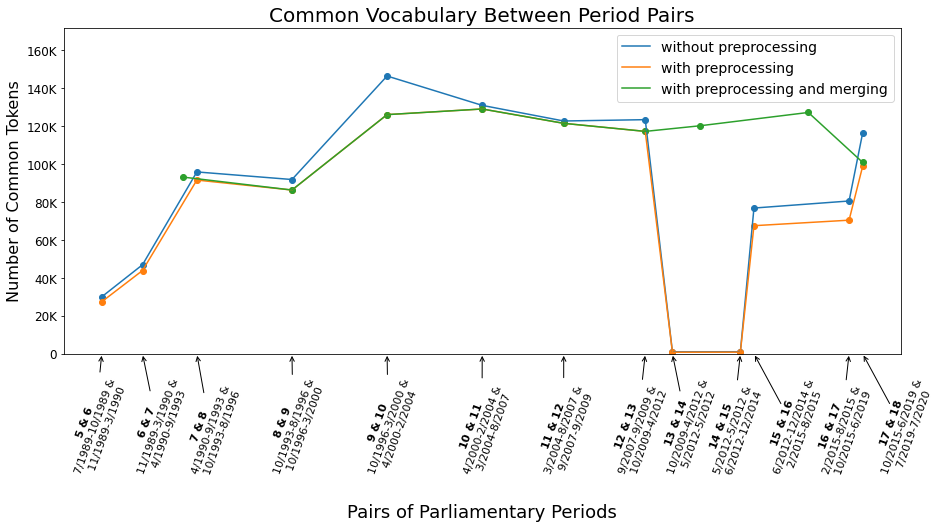

<Figure size 432x288 with 0 Axes>

In [9]:
fig = plt.figure(figsize=(15, 6))
colors = sns.color_palette("hls", 90) #90 is available pairs

plt.rcParams.update({'font.size': 12})

versions = list(set(all_versions_df.version.to_list()))
                
for version in versions:
    
    Y = all_versions_df.loc[(all_versions_df['version']==version)].common_vocab.to_list()
    X = all_versions_df.loc[(all_versions_df['version']==version)]['period_middle'].to_list()

    plt.scatter(X,Y)

    plt.plot(X,Y)


xticks = common_vocab_df_original['period_middle'].unique()
xtick_labels = [ periods_to_dates(x) for x in sorted(common_vocab_df_original['pair'].unique()) ]

plt.xlabel('Pairs of Parliamentary Periods', fontsize=18, labelpad=150)
plt.ylabel('Number of Common Tokens', fontsize=16)

ax = plt.gca()
ax.set_ylim([0,172000])
handles, labels = ax.get_legend_handles_labels()
formatter = FuncFormatter(numerize.numerize)
ax.yaxis.set_major_formatter(formatter)
plt.title('Common Vocabulary Between Period Pairs', fontsize=20)
plt.legend(versions, loc='upper right',prop={'size': 14})


for i, xtick in enumerate(xticks):
    if i in [0,7,9,11]:
        plt.annotate(xtick_labels[i], fontsize=11, annotation_clip=False,  rotation=70,
                     bbox=dict(pad=0, facecolor="none", edgecolor="none"),
                     xy=(xtick, -0.5), ma='center', xytext=(xtick-1.5, -65000), arrowprops=dict(arrowstyle="->"))
    elif i in [3,4,5,6]:
        plt.annotate(xtick_labels[i], fontsize=11, annotation_clip=False,  rotation=70,
                     bbox=dict(pad=0, facecolor="none", edgecolor="none"),
                     xy=(xtick, -0.5), ma='center', xytext=(xtick-1.2, -65000), arrowprops=dict(arrowstyle="->"))
    elif i in [10,12]:
        plt.annotate(xtick_labels[i], fontsize=11, annotation_clip=False,  rotation=70,
                     bbox=dict(pad=0, facecolor="none", edgecolor="none"),
                     xy=(xtick, -0.5), ma='center', xytext=(xtick+0.2, -65000), arrowprops=dict(arrowstyle="->"))
    elif i in [1,2,8]:
        plt.annotate(xtick_labels[i], fontsize=11, annotation_clip=False, rotation=70, ma='center',
                     bbox=dict(pad=0, facecolor="none", edgecolor="none"),
                     xy=(xtick, -0.5), xytext=(xtick-0.7, -65000), arrowprops=dict(arrowstyle="->"))

#hide major xticks
plt.tick_params(axis='x', which='major', bottom=False, top=False, labelbottom=False)

plt.savefig('../out_files/common_vocab.png', dpi=200,  bbox_inches='tight')

plt.show()
plt.cla()
plt.clf()
fig.clear()
plt.close(fig)
